<a href="https://colab.research.google.com/github/mucarii/Rede_Neural_MNIST/blob/main/Rede_Neural_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [40]:
transform = transforms.ToTensor()

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) #cria um buffer para pegar os dados por parte

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) # carrega a parte de teste da validacao
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) #Cria um buffer para pegar os dados por parte

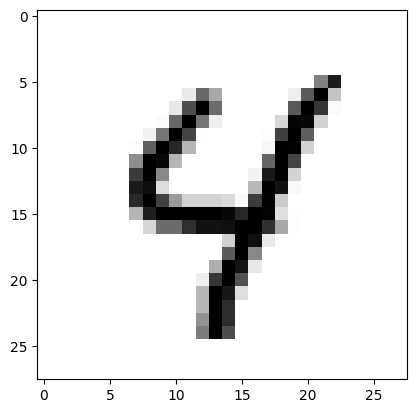

In [41]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [42]:
print(imagens[0].shape) # verificar dimensoes do tensor de cada imagem
print(etiquetas[0].shape) # verificar dimensao do tensor  de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [43]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # camada de entrada, 784 neuronios que se ligam a 128
        self.linear2 = nn.Linear(128, 64) # camada interna 1, 128 neuronios que se ligam a 64
        self.linear3 = nn.Linear(64, 10) # camada interna 2, 64 neuronios que se ligam a 10
        # para a camada de saida nao e necessario definir nada pois so precisamos pegar o output da camada interna 2
    def forward(self, x):
        x = F.relu(self.linear1(x)) # funcao de ativacao da camada de entrada interna 1
        x = F.relu(self.linear2(x)) #funcao de ativacao da camada interna 1 para a camada interna 2
        x = self.linear3(x) # funcao de ativacao da camada interna 2 para a camada de saida, nesse caso f(X) = x
        return F.log_softmax(x, dim=1) # dados utilizados para calcular a perda

In [44]:
def treino(modelo, trainloader, device):

    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # define a politica de atualizacao dos pesos e da bias
    inicio = time() # marca o inicio do treinamento

    criterio = nn.NLLLoss() # define a funcao de perda
    EPOCHS = 200 # numero de epocas
    modelo.train() # ativando o modo de treinamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0.0 # zerando a perda acumulada

        for imagens, etiquetas in trainloader:

            imagens = imagens.view(imagens.shape[0], -1) # flatten
            otimizador.zero_grad() # zerando os gradientes

            output = modelo(imagens.to(device))
            perda_instantanea = criterio(output, etiquetas.to(device)) # calcula a perda

            perda_instantanea.backward()

            otimizador.step()

            perda_acumulada += perda_instantanea.item()

        else:
            print("Época {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))

    print("\n\nTempo de treino (em minutos) = ",(time()-inicio)/60)

In [45]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagens, etiquetas in valloader:
      for i in range(len(etiquetas)):
          img = imagens[i].view(1, 784)
          # desativar o autograd para acelerar a validacao
          with torch.no_grad():
              logps = modelo(img.to(device))

          ps = torch.exp(logps) # converte outpit para escala normal
          probab = list(ps.cpu().numpy()[0])
          etiqueta_pred = probab.index(max(probab))
          etiqueta_certa = etiquetas.numpy()[i]
          if(etiqueta_certa == etiqueta_pred): #compara a previsao com o valor correto
              conta_corretas += 1
          conta_todas += 1

  print("Total de imagens testadas =", conta_todas)
  print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))

In [46]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)